In [ ]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp /content/kaggle.json ~/.kaggle/


In [ ]:
#!kaggle datasets download -d vvmansi/256-192-dataset

In [ ]:
#!unzip /content/256-192-dataset.zip

In [1]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X_train = np.load("../input/256-192-dataset/256_192_train.npy")
y_train = np.load("../input/256-192-dataset/train_labels.npy")
X_val = np.load("../input/256-192-dataset/256_192_val.npy")
y_val = np.load("../input/256-192-dataset/val_labels.npy")
X_test = np.load("../input/256-192-dataset/256_192_test.npy")
y_test = np.load("../input/256-192-dataset/test_labels.npy")

In [ ]:
#y_train = to_categorical(y_train)
#y_val = to_categorical(y_val)
#y_test = to_categorical(y_test)

In [3]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)


Training Without Fine-Tuning

In [4]:
pre_trained_model = InceptionV3(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

2022-04-09 13:51:38.221072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 13:51:38.338840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 13:51:38.340004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 13:51:38.343092: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

87924736/87910968 [==============================] - 1s 0us/step


In [5]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [6]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 2048)


In [7]:
from keras import layers
from tensorflow.keras.optimizers import Adam

# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

inception_model = Model(pre_trained_model.input, x)


In [8]:
inception_model.load_weights('../input/models/Models/InceptionV3.h5')

In [9]:
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 127, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 127, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
feature_extractor=inception_model.predict(X_train)

2022-04-09 13:52:10.688580: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4784062464 exceeds 10% of free system memory.
2022-04-09 13:52:15.472229: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4784062464 exceeds 10% of free system memory.
2022-04-09 13:52:19.101582: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-09 13:52:21.671525: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [11]:
features=feature_extractor.reshape(feature_extractor.shape[0],-1)

In [12]:
X_for_train=features

In [13]:
from sklearn.ensemble import AdaBoostClassifier as adb
 # create regressor object
model = adb()
model.fit(X_for_train, y_train)

AdaBoostClassifier()

In [14]:
X_test_feature=inception_model.predict(X_test)
X_test_features=X_test_feature.reshape(X_test_feature.shape[0],-1)

2022-04-09 13:52:55.825176: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 591003648 exceeds 10% of free system memory.
2022-04-09 13:52:56.891067: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 591003648 exceeds 10% of free system memory.


In [15]:
prediction=model.predict(X_test_features)

In [20]:
y_test.shape

(1002,)

In [16]:
from sklearn.metrics import accuracy_score
print("Accuracy= ",accuracy_score(y_test, prediction))

Accuracy=  0.7784431137724551


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt


In [21]:
cm = confusion_matrix(y_test, prediction)
print(cm)

[[  0   4   0   1   1   0  22]
 [  0  49   0   0   1   0   7]
 [  0   2   0   0  10   0  96]
 [  0   1   0   9   3   0   2]
 [  0   7   0   1 644   0  26]
 [  0   0   0   1   1  12   0]
 [  0   3   0   1  32   0  66]]


In [22]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test,prediction, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00        28
     class 1       0.74      0.86      0.80        57
     class 2       0.00      0.00      0.00       108
     class 3       0.69      0.60      0.64        15
     class 4       0.93      0.95      0.94       678
     class 5       1.00      0.86      0.92        14
     class 6       0.30      0.65      0.41       102

    accuracy                           0.78      1002
   macro avg       0.52      0.56      0.53      1002
weighted avg       0.73      0.78      0.75      1002



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
result = sensitivity_specificity_support(y_test,prediction,average='macro' )

print("Sensitivity: {:5.2f}%".format(100*result[0]), "specificity {:5.2f}%".format(100*result[1]))

Sensitivity: 55.91% specificity 95.14%


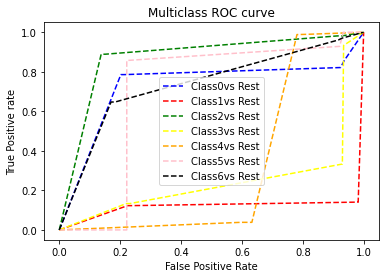

In [27]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction, pos_label=i)
    
# plotting

colors=['blue','red','green','yellow','orange','pink','black']

for i in range(0,7):
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label='Class'+ str(i) +'vs Rest')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);